# Import Libraries

In [2]:
import sys
import os

import numpy as np
import pandas as pd

import torch

import time
import datetime

import warnings

__ROOT_PATH = os.path.abspath('../')
sys.path.append(__ROOT_PATH)

from vol_surface_manager.kap_constants import *
from vol_surface_manager.kap_parse_args import parse_args
from vol_surface_manager.kap_logger import acquire_logger
from vol_surface_manager.kap_data_loader import load_data_from_config, save_coef_data_from_config, save_selection_data_from_config
from vol_surface_manager.kap_main_data import daily_coefs_to_coef_data, daily_train_data_to_selection_data
from vol_surface_manager.kap_models import HyeonukLossModel1 as LossModel
from vol_surface_manager.kap_models import HyeonukCandidateModel1 as CandidateModel
from vol_surface_manager.kap_vol_surface import create_vol_surface_at_day

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Parse Arguments

In [2]:
DATA_TYPE = "Kospi200"
VOL_DATE = "20190903"
SAVE_FIGURES = False

# ignore by message
warnings.filterwarnings("ignore", message="overflow encountered in square")
warnings.filterwarnings("ignore", message="overflow encountered in multiply")
warnings.filterwarnings("ignore", message="invalid value encountered in double_scalars")
warnings.filterwarnings("ignore", message="divide by zero encountered in double_scalars")

# 0. Parsing arguments
sys.argv = ["kap_runme_vol_surface.py",
            "--DATA_TYPE=%s" % DATA_TYPE,
            "--VOL_DATE=%s" % VOL_DATE,
            "--SAVE_FIGURES=%s" % str(SAVE_FIGURES)]
config = parse_args()
logger = acquire_logger(config)

# Acquire Market Data

In [3]:
# 1. Select date to create vol surface.
if config.VOL_DATE == -1:
    vol_day = pd.Timestamp(datetime.date.today())
else:
    vol_day = pd.Timestamp(datetime.datetime.strptime(str(config.VOL_DATE), '%Y%m%d'))

logger.info('Considering %s index. Creating vol surface at date: %s.' % (
    config.DATA_TYPE, vol_day.strftime('%Y/%m/%d')))

# 2. Acquiring market data
market_data, raw_param_data, coef_data, all_days, coef_days, market_days = load_data_from_config(
    config, logger, mode='eval')
logger.info('Market data is loaded.')

try:
    assert(vol_day in all_days)
except Exception as e:
    logger.fatal('No param data exists for date %s.' % vol_day.strftime('%Y/%m/%d'))
    raise e
day_index = all_days.index(vol_day)
try:
    assert(day_index > 0)
except Exception as e:
    logger.fatal('No param data exists for yesterday of date %s.' %
                 vol_day.strftime('%Y/%m/%d'))
    raise e
vol_yesterday = all_days[day_index-1]
try:
    assert(vol_yesterday in coef_days)
except Exception as e:
    logger.fatal('No coef data exists for yesterday of date %s: %s.' %
                 (vol_day.strftime('%Y/%m/%d'), vol_yesterday.strftime('%Y/%m/%d')))
    raise e
logger.info('Using raw parameters of date: %s and vol surface of date: %s.' %
            (vol_day.strftime('%Y/%m/%d'), vol_yesterday.strftime('%Y/%m/%d')))

    INFO - Considering Kospi200 index. Creating vol surface at date: 2019/09/03.
 WARNING - Cannot load market data from path "../data/Kospi200_Data.xlsx". But this is not necessary.
    INFO - Market data is loaded.
    INFO - Using raw parameters of date: 2019/09/03 and vol surface of date: 2019/09/02.


# Load Models

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    assert(os.path.isdir(config.MODEL_BASE_DIR))
except Exception as e:
    logger.fatal('Invalid model directory: "%s."' % config.MODEL_BASE_DIR)
    raise e

# 2. Loading loss models
alpha_loss_model, rho_loss_model, nu_loss_model = None, None, None
LOSS_MODEL_DIRNAME = 'loss_models'
loss_model_base_dir = os.path.join(config.MODEL_BASE_DIR, LOSS_MODEL_DIRNAME)
loss_model_base_dir_2 = os.path.join(loss_model_base_dir, config.DATA_TYPE)
for parameter in ['Alpha', 'Rho', 'Nu']:
    loss_model_save_dir = os.path.join(loss_model_base_dir_2, parameter)
    loss_model_name = 'model_best.th'
    loss_model_file = os.path.join(loss_model_save_dir, loss_model_name)
    try:
        loss_model = LossModel(device, parameter=parameter)
        with open(loss_model_file, 'rb') as f:
            checkpoint = torch.load(f)
            loss_model.load_state_dict(checkpoint['state_dict'])
        loss_model.eval()
        logger.info('%s loss model is loaded.' % parameter)
    except:
        loss_model = None
        logger.warning('No %s loss model exists.' % parameter)
    if parameter == 'Alpha':
        alpha_loss_model = loss_model
    elif parameter == 'Rho':
        rho_loss_model = loss_model
    else:
        assert(parameter == 'Nu')
        nu_loss_model = loss_model

# 3. Loading candidate models
alpha_candidate_model, rho_candidate_model, nu_candidate_model = None, None, None
CANDIDATE_MODEL_DIRNAME = 'candidate_models'
candidate_model_base_dir = os.path.join(config.MODEL_BASE_DIR, CANDIDATE_MODEL_DIRNAME)
candidate_model_base_dir_2 = os.path.join(candidate_model_base_dir, config.DATA_TYPE)
for parameter in ['Alpha', 'Rho', 'Nu']:
    candidate_model_save_dir = os.path.join(candidate_model_base_dir_2, parameter)
    candidate_model_name = 'model_best.th'
    candidate_model_file = os.path.join(candidate_model_save_dir, candidate_model_name)
    try:
        candidate_model = CandidateModel(device, parameter=parameter)
        with open(candidate_model_file, 'rb') as f:
            checkpoint = torch.load(f)
            candidate_model.load_state_dict(checkpoint['state_dict'])
        candidate_model.eval()
        logger.info('%s candidate model is loaded.' % parameter)
    except:
        candidate_model = None
        logger.warning('No %s candidate model exists.' % parameter)
    if parameter == 'Alpha':
        alpha_candidate_model = candidate_model
    elif parameter == 'Rho':
        rho_candidate_model = candidate_model
    else:
        assert (parameter == 'Nu')
        nu_candidate_model = candidate_model

    INFO - Alpha loss model is loaded.
    INFO - Rho loss model is loaded.
    INFO - Nu loss model is loaded.
    INFO - Alpha candidate model is loaded.
    INFO - Rho candidate model is loaded.
    INFO - Nu candidate model is loaded.


# Create Vol Surface

    INFO - 
    INFO - Now creating vol surface.
    INFO - 
    INFO - Computed Alpha Coefficients: 0.172856, 0.408352, 7.676978, -0.021563, 0.584647
    INFO - Elapsed time:   144 seconds.
    INFO - 


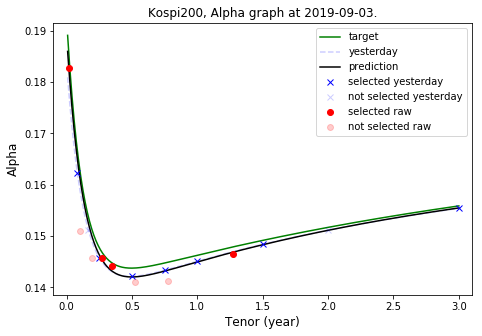

    INFO - Computed Rho Coefficients: -0.364249, -0.198828, 1.146335
    INFO - Elapsed time:   231 seconds.
    INFO - 


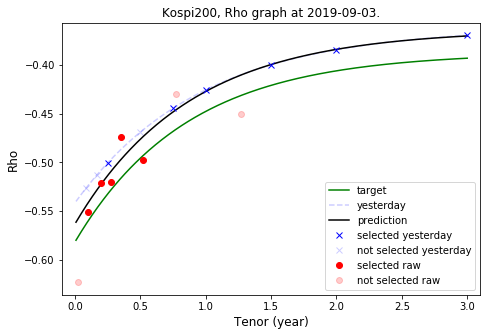

    INFO - Computed Nu Coefficients: 0.162440, 0.662094, -0.417129, -0.291109
    INFO - Elapsed time:   348 seconds.
    INFO - 


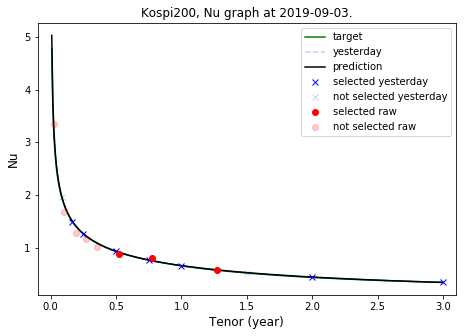

    INFO - Vol surface is created.
    INFO - Elapsed time:   348 seconds.
    INFO - 


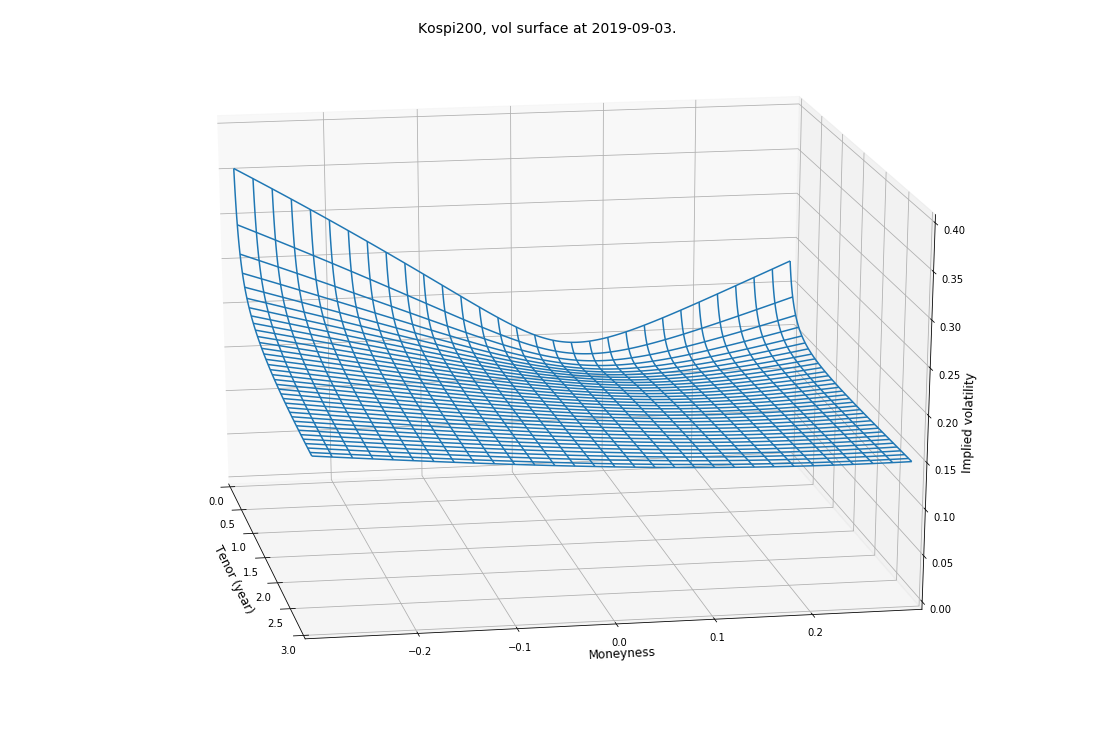

    INFO - Finally writing the results to excel format.
    INFO - 


In [5]:
# 5. Create vol surface.
try:
    assert(os.path.isdir(config.RESULT_BASE_DIR))
except Exception as e:
    logger.fatal('Invalid result directory: "%s."' % config.RESULT_BASE_DIR)
    raise e
if config.SAVE_FIGURES == 'True':
    save_base_name = os.path.join(config.RESULT_BASE_DIR, 'vol_surface_%s_%s' % (
        config.DATA_TYPE, vol_day.strftime('%Y%m%d')))
else:
    assert(config.SAVE_FIGURES == 'False')
    save_base_name = ''
if config.PLOT_FIGURES == 'True':
    plot_result = True
else:
    assert(config.PLOT_FIGURES == 'False')
    plot_result = False

pred_alpha_coefs, pred_rho_coefs, pred_nu_coefs, \
    daily_alpha_train_data, daily_rho_train_data, daily_nu_train_data = create_vol_surface_at_day(
    logger, config, vol_day, vol_yesterday, market_data, raw_param_data, coef_data,
    alpha_loss_model, alpha_candidate_model,
    nu_loss_model, nu_candidate_model,
    rho_loss_model, rho_candidate_model, save_base_name, plot_result)

# 6. Save the results.
logger.info('Finally writing the results to excel format.')
pred_coef_data = daily_coefs_to_coef_data(vol_day, pred_alpha_coefs, pred_rho_coefs, pred_nu_coefs)
save_coef_data_from_config(config, pred_coef_data)
pred_alpha_selection_data = daily_train_data_to_selection_data(daily_alpha_train_data)
pred_rho_selection_data = daily_train_data_to_selection_data(daily_rho_train_data)
pred_nu_selection_data = daily_train_data_to_selection_data(daily_nu_train_data)
save_selection_data_from_config(
    config, pred_alpha_selection_data, pred_rho_selection_data, pred_nu_selection_data)
logger.info('')